In [1]:
import random
import numpy as np
import keras
import wandb
from wandb.keras import WandbCallback
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from keras.datasets import mnist
from keras.optimizers import Adam
import matplotlib.pyplot as plt



Using TensorFlow backend.


In [2]:
# load data

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [3]:
# make pairs
def make_pairs(x, y):
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [1]
    
        # add a not matching example
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels)

pairs_train, labels_train = make_pairs(x_train, y_train)
pairs_test, labels_test = make_pairs(x_test, y_test)

1


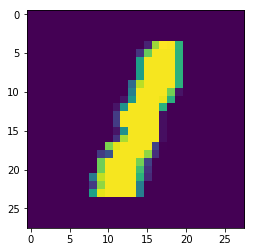

In [4]:
# take a peek at the data
plt.imshow(pairs_train[400,1])
print(labels_train[4])

In [5]:
# Weights not shared

seq1 = Sequential()
seq1.add(Flatten(input_shape=(28,28)))
seq1.add(Dense(128, activation='relu'))

seq2 = Sequential()
seq2.add(Flatten(input_shape=(28,28)))
seq2.add(Dense(128, activation='relu'))

merge_layer = Concatenate()([seq1.output, seq2.output])
dense_layer = Dense(1, activation="sigmoid")(merge_layer)
model = Model(inputs=[seq1.input, seq2.input], outputs=dense_layer)


In [6]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
flatten_1_input (InputLayer)    (None, 28, 28)       0                                            
__________________________________________________________________________________________________
flatten_2_input (InputLayer)    (None, 28, 28)       0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           flatten_1_input[0][0]            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           flatten_2_input[0][0]            
__________________________________________________________________________________________________
dense_1 (D

In [7]:
wandb.init(project="siamese")
model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=16, epochs= 10, callbacks=[WandbCallback()])

W&B Run: https://app.wandb.ai/l2k2/siamese/runs/6v1gb888
Call `%%wandb` in the cell containing your training loop to display live results.
Epoch 1/10
120000/120000 [==============================] - 38s 317us/step - loss: 0.6947 - acc: 0.5010
Epoch 2/10
120000/120000 [==============================] - 38s 314us/step - loss: 0.6931 - acc: 0.5054
Epoch 3/10
120000/120000 [==============================] - 38s 317us/step - loss: 0.6930 - acc: 0.5072
Epoch 4/10
120000/120000 [==============================] - 35s 290us/step - loss: 0.6928 - acc: 0.5087
Epoch 5/10
120000/120000 [==============================] - 35s 289us/step - loss: 0.6924 - acc: 0.5082
Epoch 6/10
120000/120000 [==============================] - 35s 289us/step - loss: 0.6920 - acc: 0.5130
Epoch 7/10
120000/120000 [==============================] - 37s 309us/step - loss: 0.6914 - acc: 0.5140
Epoch 8/10
120000/120000 [==============================] - 38s 314us/step - loss: 0.6906 - acc: 0.5168
Epoch 9/10
120000/120000 [===

In [15]:
input = Input((28,28))
x = Flatten()(input)
x = Dense(128, activation='relu')(x)
dense = Model(input, x)

input1 = Input((28,28))
input2 = Input((28,28))

dense1 = dense(input1)
dense2 = dense(input2)

merge_layer = Concatenate()([dense1, dense2])
dense_layer = Dense(1, activation="sigmoid")(merge_layer)
model = Model(inputs=[input1, input2], outputs=dense_layer)


In [16]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 128)          100480      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 256)          0           model_4[1][0]                    
          

In [17]:
wandb.init(project="siamese")
model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=16, epochs=10, callbacks=[WandbCallback()])

W&B Run: https://app.wandb.ai/l2k2/siamese/runs/ah312s1c
Call `%%wandb` in the cell containing your training loop to display live results.
Epoch 1/10
120000/120000 [==============================] - 37s 306us/step - loss: 0.6941 - acc: 0.4981
Epoch 2/10
120000/120000 [==============================] - 35s 288us/step - loss: 0.6933 - acc: 0.5082
Epoch 3/10
 25248/120000 [=====>........................] - ETA: 25s - loss: 0.6930 - acc: 0.5032

KeyboardInterrupt: 

In [18]:
from keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


input = Input((28,28))
x = Flatten()(input)
x = Dense(128, activation='relu')(x)
dense = Model(input, x)

input1 = Input((28,28))
input2 = Input((28,28))

dense1 = dense(input1)
dense2 = dense(input2)

merge_layer = Lambda(euclidean_distance)([dense1,dense2])
dense_layer = Dense(1, activation="sigmoid")(merge_layer)
model = Model(inputs=[input1, input2], outputs=dense_layer)


In [19]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
model_6 (Model)                 (None, 128)          100480      input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_6[1][0]                    
          

In [20]:
wandb.init(project="siamese")
model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=16, epochs=10, callbacks=[WandbCallback()])

W&B Run: https://app.wandb.ai/l2k2/siamese/runs/34u8rkzs
Call `%%wandb` in the cell containing your training loop to display live results.
Epoch 1/10
120000/120000 [==============================] - 39s 324us/step - loss: 0.4544 - acc: 0.7934
Epoch 2/10
120000/120000 [==============================] - 40s 337us/step - loss: 0.3598 - acc: 0.8500
Epoch 3/10
120000/120000 [==============================] - 40s 336us/step - loss: 0.3391 - acc: 0.8585
Epoch 4/10
120000/120000 [==============================] - 41s 344us/step - loss: 0.3251 - acc: 0.8645
Epoch 5/10
120000/120000 [==============================] - 41s 340us/step - loss: 0.3147 - acc: 0.8700
Epoch 6/10
120000/120000 [==============================] - 39s 328us/step - loss: 0.3116 - acc: 0.8714
Epoch 7/10
120000/120000 [==============================] - 36s 303us/step - loss: 0.3099 - acc: 0.8720
Epoch 8/10
120000/120000 [==============================] - 39s 328us/step - loss: 0.3084 - acc: 0.8728
Epoch 9/10
120000/120000 [===

array([[5.0249963],
       [5.2089543],
       [3.201473 ],
       [5.975113 ],
       [4.750642 ],
       [5.159156 ],
       [3.20649  ],
       [4.343628 ],
       [4.144156 ],
       [4.6518426],
       [5.0975466],
       [5.408521 ],
       [1.4890893],
       [4.7235627],
       [6.125441 ],
       [4.906605 ],
       [5.3288717],
       [5.8312774],
       [3.9407134],
       [3.7102926],
       [3.0666695],
       [4.858267 ],
       [3.1148467],
       [5.1245933],
       [5.438567 ],
       [6.089241 ],
       [4.323873 ],
       [5.2438707],
       [3.6994154],
       [8.483834 ],
       [2.2479403],
       [5.1236877],
       [5.4368477],
       [4.468987 ],
       [5.3873725],
       [6.7580404],
       [3.3060052],
       [5.1335177],
       [4.319157 ],
       [5.0302362],
       [4.6010137],
       [5.50213  ],
       [4.0740275],
       [5.5968795],
       [3.6118877],
       [6.381815 ],
       [2.0798607],
       [5.61024  ],
       [4.9588966],
       [5.2881026],
